## Summary:
**Name:** General EnKF template  
**Author:** Siyang Jing  
**Organization:** UNC-CH  
**License:** WTFPL  

**Reference:**
1. Amit Apte's EnKF code in Python
1. Christian Sampson's EnKF code in matlab
1. The author's other codes
1. Relevant numerous papers
  
**Description:**  
This file implements a full stochastic Ensemble Kalman Filter template for arbitrary model and observation operator. It also supports:
1. Linear EnKF
1. Error in observation operator
1. Error in model
  
**Requirements:**
1. Relevant Python modules
1. AuxFuncs, which defines the following:  
 1. Observation operator  
 1. Stupid inverse function  
 1. Lorenz96 as model

## TODO list:
1. Change $H$ to function **Done**
1. Change KF to non-linear **Done**
1. Write own RK4
1. Use different $H$ for generation and linear KF **Done**
1. Inflation algorithm **Done**
1. Calculate statistics
1. Add proper plotting **Done**
1. Write pipeline code to automate the process
1. Functionalize this file

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as scp
import scipy.integrate

import AuxFuncs

In [104]:
#### Paramters

## Notebook usage flags
PLOTTING = True
LINEAR = False
FORECAST_ERROR = True
INFLATION = True
DEBUG = True

## Model parameters
ndim = 40
F = 8.0
pars = (F)

# True model
def TM(xin,tin,pars):
    return AuxFuncs.l96rhs(xin,tin,pars)

# Forcast model
def TF(xin,tin,pars):
    return AuxFuncs.l96rhs(xin,tin,pars)

# Potentially different to introduce model error

## Observation paramters
nobs = 50
deltaobs = 0.1

## Setting for direct observation
'''
dobs = 20

# True observation operator
def H(x):
    return AuxFuncs.ObsOp_40_20(x)

# The observation operator that we think is true
def Hm(x):
    return AuxFuncs.ObsOp_40_20(x)
'''

## Setting for stupid inversion case
#'''
dobs = 10

# True observation operator
def H(x):
    return AuxFuncs.Inv_20_10(AuxFuncs.ObsOp_40_20(x))

# Used for linearized case
Hmat = np.zeros([dobs,ndim])
for i in np.arange(dobs):
    Hmat[i,i] = 1.0

# The observation operator that we think is true
def Hm(x):
    return Hmat @ x
    # return H(x)

LINEAR = True
#'''

# Suggested value
# Could also choose from long trajectory
sigmaobs = 0.9

## DA paramters
infl_lin = 0.5
infl_nlin = 1
sigmainit = 1.3
nens = 100
ferr = 1.0


In [105]:
## find an initial condition on the attractor

xrand = np.random.rand(ndim)
ttrans = np.linspace(0,100,1000)
xtrans = scp.integrate.odeint(TM, xrand, ttrans, (pars,))

t = np.linspace(0,50,100000)
xattr = xtrans[-1,:]

(10000, 40)


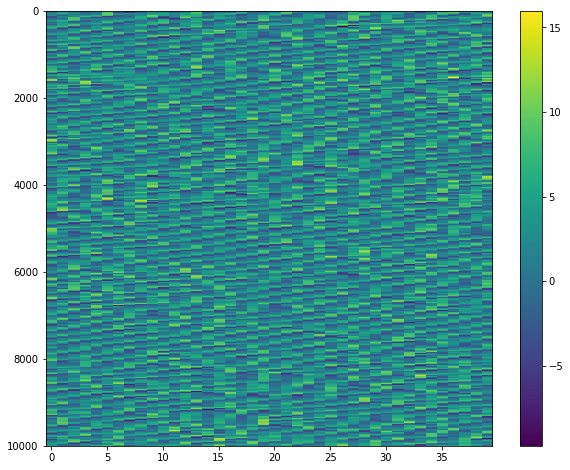

In [106]:
## plot a long trajectory...

tlong = np.linspace(0,100,10000)
xlong = scp.integrate.odeint(TM, xattr, tlong, (pars,))
print(xlong.shape)

# Plotting
plt.figure(figsize=(10, 8))
plt.imshow(xlong, aspect='auto')
plt.colorbar()

#sigmaobs = np.abs(np.max(xlong[:,0]) - np.min(xlong[:,0]))/50


In [107]:
## generate true trajectory

tend = nobs * deltaobs
tobs = np.linspace(0, tend, num=nobs+1)
ttraj = np.linspace(0, tend, num=nobs*100+1)
truetraj = scp.integrate.odeint(TM, xattr, ttraj, (pars,))
truestate = truetraj[::100,:]

truestate = truestate.T

In [108]:
## generate observations

trueobs = H(truestate)
robs = sigmaobs*sigmaobs
Robsmat = np.identity(dobs)*robs
yobs = trueobs + np.random.multivariate_normal(np.zeros(dobs), Robsmat,nobs+1).T


In [109]:

sigmainit = sigmaobs*10

## Containers
xfm = np.zeros([nobs+1, ndim])
xam = np.zeros([nobs+1, ndim])
xfcov = np.zeros([nobs+1, ndim, ndim])
xacov = np.zeros([nobs+1, ndim, ndim])

yfm = np.zeros([nobs+1, dobs])
yfcov = np.zeros([nobs+1, dobs, dobs])

## set the initial mean and covariance:
xam[0,:] = xattr + sigmainit*np.random.randn(*xattr.shape)
xacov[0,:,:] = np.identity(ndim)*sigmainit*sigmainit

## Generate initial ensemble
xens = np.random.multivariate_normal(xam[0,:], xacov[0,:,:], nens)

## Iterate for each observation
for ii in np.arange(1,nobs+1):
    
    ## Forecast
    for jj in np.arange(nens):
        xens[jj,:] = scp.integrate.odeint(TF, xens[jj,:], [tobs[ii-1], tobs[ii]], (pars,))[-1,:]
        if DEBUG:
            print('.',end='')
        if FORECAST_ERROR:
        # Introduce forecast model error
            xens[jj,:] += ferr * np.random.randn(ndim)
        
    ## Forecast mean and cov
    xfm[ii,:] = np.mean(xens,axis=0)
    xfcov[ii,:,:] = np.cov(xens.T)
    
    ## Observations generated from forecast
    ## Estimating the covariances with sample covariance
    yens = Hm(xens.T).T
    yfm[ii,:] = np.mean(yens,axis=0)
    yfcov[ii,:,:] = np.cov(yens.T)
    
    ## Kalman gain:
    if LINEAR:
    # Linear EnKF
        pf = xfcov[ii,:,:]
        
        if INFLATION:
        # inflation
            pf += infl_lin*np.trace(xfcov[ii,:,:])/ndim*np.identity(ndim)
            
        pfht = pf @ Hmat.T
        kgain = pfht @ np.linalg.pinv( Hmat @ pfht + Robsmat)
    
    else:
    # Nonlinear EnKF
        Ex = xens - xfm[ii,:]
        Ey = yens - yfm[ii,:]    
        Bxy = Ex.T @ Ey / (nens-1)
        Byy = yfcov[ii,:,:]
        
        if INFLATION:
        # Inflation
            Byy += infl_nlin*Robsmat
        kgain = Bxy @ np.linalg.pinv(Byy)
    
    ## Update ensemble members
    pertobs = np.random.multivariate_normal(yobs[:,ii],Robsmat,nens)
    
    for jj in np.arange(nens):
        xens[jj,:] += kgain @ (pertobs[jj,:] - Hm(xens[[jj],:].T).flatten())
    
    ## Analysis mean and cov
    xam[ii,:] = np.mean(xens,axis=0)
    xacov[ii,:,:] = np.cov(xens.T)
    
    if DEBUG:
        print(ii)

....................................................................................................1
....................................................................................................2
....................................................................................................3
....................................................................................................4
....................................................................................................5
....................................................................................................6
....................................................................................................7
....................................................................................................8
....................................................................................................9
..................................................................................

In [110]:
## some plotting functions
def plotwitherrorbarsobsplt(iob, itr, nsig, cvflag):
    lt, = plt.plot(ttraj, truetraj[:,itr])
    lf, = plt.plot(tobs[1:], xfm[1::,itr], '.-')
    la, = plt.plot(tobs, xam[:,itr], '.-')
    if cvflag:
        errf = np.sqrt(xfcov[:,itr,itr])*nsig
        plt.fill_between(tobs[1:], xfm[1:,itr] - errf[1:], xfm[1:,itr] + errf[1:], alpha=0.5, color = lf.get_color())
        erra = np.sqrt(xacov[:,itr,itr])*nsig
        plt.fill_between(tobs[1:], xam[1:,itr] - erra[1:], xam[1:,itr] + erra[1:], alpha=0.5, color = la.get_color())

def plotwitherrorbarsnoobplt(itr, nsig, cvflag):
    lt, = plt.plot(ttraj, truetraj[:,itr])
    lf, = plt.plot(tobs[1:], xfm[1::,itr], '.-')
    la, = plt.plot(tobs, xam[:,itr], '.-')
    if cvflag:
        errf = np.sqrt(xfcov[:,itr,itr])*nsig
        plt.fill_between(tobs[1:], xfm[1:,itr] - errf[1:], xfm[1:,itr] + errf[1:], alpha=0.5, color = lf.get_color())
        erra = np.sqrt(xacov[:,itr,itr])*nsig
        plt.fill_between(tobs[1:], xam[1:,itr] - erra[1:], xam[1:,itr] + erra[1:], alpha=0.5, color = la.get_color())

# For subplots
def plotwitherrorbarsobsax(iob, itr, nsig, cvflag):
    lt, = ax.plot(ttraj, truetraj[:,itr])
    lf, = ax.plot(tobs[1:], xfm[1:,itr], '.-')
    la, = ax.plot(tobs[1:], xam[1:,itr], '.-')
    if cvflag:
        errf = np.sqrt(xfcov[:,itr,itr])*nsig
        ax.fill_between(tobs[1:], xfm[1:,itr] - errf[1:], xfm[1:,itr] + errf[1:], alpha=0.5, color = lf.get_color())
        erra = np.sqrt(xacov[:,itr,itr])*nsig
        ax.fill_between(tobs[1:], xam[1:,itr] - erra[1:], xam[1:,itr] + erra[1:], alpha=0.5, color = la.get_color())

def plotwitherrorbarsnoobax(itr, nsig, cvflag):
    lt, = ax.plot(ttraj, truetraj[:,itr])
    lf, = ax.plot(tobs[1:], xfm[1:,itr], '.-')
    la, = ax.plot(tobs[1:], xam[1:,itr], '.-')
    if cvflag:
        errf = np.sqrt(xfcov[:,itr,itr])*nsig
        ax.fill_between(tobs[1:], xfm[1:,itr] - errf[1:], xfm[1:,itr] + errf[1:], alpha=0.5, color = lf.get_color())
        erra = np.sqrt(xacov[:,itr,itr])*nsig
        ax.fill_between(tobs[1:], xam[1:,itr] - erra[1:], xam[1:,itr] + erra[1:], alpha=0.5, color = la.get_color())


In [ ]:
## plot observed variables
cvflag = True

nsig=3
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13,7))
for ii, ax in enumerate(axes.flat, start=1):
    iob = ii-1
    itr = iob
    plotwitherrorbarsobsax(iob, itr, nsig, cvflag)
    ax.grid()
fig.tight_layout()

## plot some of the unobserved variables
nsig=3
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13,7))
for ii, ax in enumerate(axes.flat, start=1):
    itr = ii + 20
    plotwitherrorbarsnoobax(itr, nsig, cvflag)
    ax.grid()
fig.tight_layout()


In [ ]:
vmin=np.min((np.min(truestate),np.min(xfm),np.min(xam)))
vmax=np.min((np.max(truestate),np.max(xfm),np.max(xam)))

plt.figure(figsize=(17,6))
plt.subplot(1,3,1)
plt.imshow(truestate, aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(xfm.T, aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(xam.T, aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar()